In [1]:
%load_ext autoreload
%autoreload 2
import os
import os.path
import numpy as np
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.ensemble
import spacy
import sys
from sklearn.feature_extraction.text import CountVectorizer
from anchor import anchor_text
import time
from myUtils import *
import pickle
import matplotlib.pyplot as plt

In [5]:
# dataset from http://www.cs.cornell.edu/people/pabo/movie-review-data/
# Link: http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
def load_polarity(path='sentiment-sentences'):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            try:
                line.decode('utf8')
            except:
                continue
            data.append(line.strip())
            labels.append(l)
    return data, labels

Note: you must have spacy installed. Run:

        pip install spacy && python -m spacy download en_core_web_sm

If you want to run BERT, you have to install transformers and torch or tf: 

        pip install torch transformers spacy && python -m spacy download en_core_web_sm
        

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
data, labels = load_polarity()
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(data, labels, test_size=.2, random_state=42)
train, val, train_labels, val_labels = sklearn.model_selection.train_test_split(train, train_labels, test_size=.1, random_state=42)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

In [10]:
vectorizer = CountVectorizer(min_df=1)
vectorizer.fit(train)
train_vectors = vectorizer.transform(train)
test_vectors = vectorizer.transform(test)
val_vectors = vectorizer.transform(val)

In [11]:
c = sklearn.linear_model.LogisticRegression()
# c = sklearn.ensemble.RandomForestClassifier(n_estimators=500, n_jobs=10)
c.fit(train_vectors, train_labels)
preds = c.predict(val_vectors)
print('Val accuracy', sklearn.metrics.accuracy_score(val_labels, preds))
def predict_lr(texts):
    return c.predict(vectorizer.transform(texts))

Val accuracy 0.7544910179640718


c:\users\alon\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Explaining a prediction
use_unk_distribution=True means we will perturb examples by replacing words with UNKS

## Using BERT

The distribution above is a bit naive, and you get a lot of sentences that don't look realistic.  
Let's use BERT to perturb the data:

In [13]:
explainer = anchor_text.AnchorText(nlp, ['negative', 'positive'], use_unk_distribution=False)

In [8]:
test = [example.decode('utf-8') for example in test]
anchor_examples = [example.decode('utf-8') for example in train]
anchor_examples = [example for example in anchor_examples if 20< len(example) < 70 and len(example)>20][:500]

In [9]:
pickle.dump( test, open( "results/text_test.pickle", "wb" ))
pickle.dump( test_labels, open( "results/text_test_labels.pickle", "wb" ))

In [ ]:
my_utils = TextUtils(anchor_examples, test, explainer, predict_lr)
#explanations = my_utils.compute_explanations(np.random.choice(len(test), exps_num))
explanations = my_utils.compute_explanations(list(range(0, len(anchor_examples))))

In [ ]:
pickle.dump( explanations, open( "results/text_exps.pickle", "wb" ))


# Loading Results

In [26]:
explanations = pickle.load( open( "results/text_exps.pickle", "rb" ))
test = pickle.load( open( "results/text_test.pickle", "rb" ))
test = np.array(test)
test_labels = pickle.load( open( "results/text_test_labels.pickle", "rb" ))

In [ ]:
myUtils =  TextUtils(test, test, None, None, "results/transformer_exps.pickle")
explanations = myUtils.remove_duplicates(explanations)

In [ ]:
explanations = [ExtendedExplanation(exp, test, test_labels, predict_sentences, explainer) for exp in explanations if len(exp.fit_examples) > 10]

In [ ]:
explanations = [exp for exp in explanations if len(exp.fit_examples) > 10] 
explanations.sort(key=lambda exp: exp.test_precision)

In [27]:
best = explanations[-10:]
best.reverse()

for exp in best:
    print("------------------------")
    exp_label =  predict_lr([test[exp.index]])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % (np.mean(predict_lr(test[exp.fit_examples]) == exp_label)))
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = test_labels[exp.fit_examples]
    real_percentage = np.mean(covered_labels == exp_label)
    print('Anchor test REAL precision: %.2f' % real_percentage)

------------------------
Prediction: negative
Anchor: no AND no
Precision: 0.98
Coverage: 0.00
Anchor test precision: 0.56
Anchor test coverage: 0.25
Anchor test REAL precision: 0.56
------------------------
Prediction: positive
Anchor: no
Precision: 0.99
Coverage: 0.00
Anchor test precision: 0.44
Anchor test coverage: 0.25
Anchor test REAL precision: 0.44
------------------------
Prediction: negative
Anchor: so
Precision: 0.97
Coverage: 0.00
Anchor test precision: 0.55
Anchor test coverage: 0.23
Anchor test REAL precision: 0.53
------------------------
Prediction: positive
Anchor: do
Precision: 0.96
Coverage: 0.00
Anchor test precision: 0.45
Anchor test coverage: 0.16
Anchor test REAL precision: 0.46
------------------------
Prediction: negative
Anchor: ill
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.47
Anchor test coverage: 0.12
Anchor test REAL precision: 0.47
------------------------
Prediction: positive
Anchor: so AND -
Precision: 0.96
Coverage: 0.00
Anchor test precis

In [29]:
exps = explanations[:-len(explanations)//2]
exps = [exp for exp in exps if len(exp.fit_examples)>10]
real_precisions = [exp.real_precision for exp in exps]
test_precisions = [exp.test_precision for exp in exps]

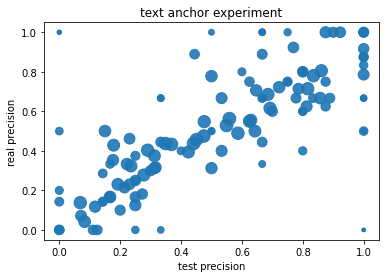

In [30]:
plt.scatter(test_precisions, real_precisions, s = range(len(exps)), alpha = 0.9)
plt.xlabel('test precision')
plt.ylabel('real precision')
plt.title('text anchor experiment')
plt.savefig("results/text.png")

In [ ]:
img = plt.imread("results/text.png")
plt.figure(figsize = (10,10))
plt.axis('off')
_ = plt.imshow(img)

In [ ]:
np.random.seed(1)
text = 'This is a good book .'
pred = explainer.class_names[predict_lr([text])[0]]
alternative =  explainer.class_names[1 - predict_lr([text])[0]]
print('Prediction: %s' % pred)
b = time.time()
exp = explainer.explain_instance(text, predict_lr, threshold=0.95, verbose=False)
print('Time: %s' % (time.time() - b))

In [ ]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(only_different_prediction=True)]))

Let's take a look at the partial anchor 'good' to see why it's not sufficient in this case


In [ ]:
print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Note how the examples are much more realistic than just using UNKS.

## See a visualization of the anchor with examples and etc (won't work if you're seeing this on github)

In [ ]:
exp.show_in_notebook()